<a href="https://colab.research.google.com/github/shwbak/HAI-Anomaly-Detection/blob/main/AutoEncoder%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_Anomaly_Detection_%EC%BD%94%EB%93%9C%EC%A0%95%EB%A6%AC_%ED%9B%84%EC%B2%98%EB%A6%AC%EC%B6%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SSH 키 발급

In [ ]:
!ssh-keygen

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): ^C


In [ ]:
%cd ~/.ssh/

/root/.ssh


In [ ]:
! cat id_rsa.pub

cat: id_rsa.pub: No such file or directory


# Git 연동 확인

In [ ]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

/bin/bash: /root/.ssh/known_hosts: No such file or directory


In [ ]:
!ssh -T git@github.com

Host key verification failed.


#구글드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Github Origin을 Pull

In [ ]:
from os.path import join
from os import makedirs

PROJ_path = "/content/drive/MyDrive/Colab Notebooks/"
%cd "{PROJ_path}"
try:
  makedirs("HAI-Anomaly-Detection")
  REPO_path = "/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/"
  %cd "{REPO_path}"
  !git init
  !git config --global user.email "minseok4864@ajou.ac.kr"
  !git config --global user.name "minseok4864"
  !git remote add origin https://github.com/shwbak/HAI-Anomaly-Detection

  !pip install --upgrade git-lfs

  !git lfs install
  !git lfs track "*.csv"
  !git add .gitattributes
except:
  print("동일한 이름의 폴더가 이미 존재합니다.")

/content/drive/MyDrive/Colab Notebooks
동일한 이름의 폴더가 이미 존재합니다.


Pull 코드

In [ ]:
REPO_path = "/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/"
%cd "{REPO_path}"

!pip install --upgrade git-lfs

!git init
!git config --global user.email "minseok4864@ajou.ac.kr"
!git config --global user.name "minseok4864"
!git pull origin main

/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reinitialized existing Git repository in /content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/.git/
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), 583.06 KiB | 383.00 KiB/s, done.
From https://github.com/shwbak/HAI-Anomaly-Detection
 * branch            main       -> FETCH_HEAD
   3a7da8b..7b4d434  main       -> origin/main
Updating 3a7da8b..7b4d434
Fast-forward
 ...54\232\251\355\225\234_Anomaly_Detection.ipynb" | 283 ++++++++++++++-------
 ...2\251\355\225\234_Anomaly_Detection_ipyn.ipynb" |  20 +-
 2 files changed, 208 insertions(+), 95 deletions(-)
fatal: cannot exec '.git/hooks/post-merge': Permission denied


#오토인코더 모델 및 raw 데이터 준비

In [65]:
REPO_path = "/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/"
%cd "{REPO_path}"
!pip install eTaPR-21.8.2-py3-none-any.whl

/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./eTaPR-21.8.2-py3-none-any.whl
eTaPR is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def plot_history(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x', label="loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title('Losses vs. No. of epochs')
    plt.grid()
    plt.show()

In [67]:
import torch.nn as nn

device = get_default_device()


class Autoencoder(nn.Module):
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_size, int(in_size/2)),
            nn.ReLU(True),
            nn.Linear(int(in_size/2), int(in_size/4)),
            nn.ReLU(True),
            nn.Linear(int(in_size/4), latent_size),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, int(in_size/4)),
            nn.ReLU(True),
            nn.Linear(int(in_size/4), int(in_size/2)),
            nn.ReLU(True),
            nn.Linear(int(in_size/2), in_size),
            nn.Sigmoid()
        )
  
    def training_step(self, batch, epoch):
        z = self.encoder(batch)
        out = self.decoder(z)
        loss1 = nn.MSELoss()(out, batch)
        loss2 = nn.L1Loss()(out, batch)
        return loss1, loss2

    def validation_step(self, batch, epoch):
        z = self.encoder(batch)
        out = self.decoder(z)
        loss = nn.MSELoss()(out, batch)
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))


def evaluate(model, val_loader, epoch):
    outputs = [model.validation_step(to_device(batch, device), epoch) for [batch] in val_loader]
    return model.validation_epoch_end(outputs)

def training(epochs, model, train_loader, val_loader, opt_func=torch.optim.AdamW):
    history = []
    optimizer = opt_func(list(model.encoder.parameters()) + list(model.decoder.parameters()))
    for epoch in range(epochs):
        for [batch] in train_loader:
            batch = to_device(batch, device)
            loss1, loss2 = model.training_step(batch, epoch+1)
            loss1.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader, epoch + 1)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def testing(model, test_loader):
    results = []
    for [batch] in test_loader:
        batch = to_device(batch, device)
        z = model.encoder(batch)
        reconstructed = model.decoder(z)
        results.append(torch.mean((batch - reconstructed)**2, axis=1))
    return results

In [68]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr
from tqdm import tqdm

In [69]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [70]:
TRAIN_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/HAICon2021_dataset/train/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/HAICon2021_dataset/test/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection/HAICon2021_dataset/validation/").glob("*.csv")])

In [71]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.reset_index(drop=True,inplace=True)

TRAIN_DF_01 = dataframe_from_csv(TRAIN_DATASET[0])
TRAIN_DF_01.reset_index(drop=True,inplace=True)

TRAIN_DF_02 = dataframe_from_csv(TRAIN_DATASET[1])
TRAIN_DF_02.reset_index(drop=True,inplace=True)

TRAIN_DF_03 = dataframe_from_csv(TRAIN_DATASET[2])
TRAIN_DF_03.reset_index(drop=True,inplace=True)

TRAIN_DF_04 = dataframe_from_csv(TRAIN_DATASET[3])
TRAIN_DF_04.reset_index(drop=True,inplace=True)

TRAIN_DF_05 = dataframe_from_csv(TRAIN_DATASET[4])
TRAIN_DF_05.reset_index(drop=True,inplace=True)

TRAIN_DF_06 = dataframe_from_csv(TRAIN_DATASET[5])
TRAIN_DF_06.reset_index(drop=True,inplace=True)

print(TRAIN_DF_RAW.shape)
TRAIN_DF_RAW.head()

(1004402, 87)


,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503


아래 두 목록에는 중복된 장치들이 있으니 이 점 유의하시면 좋을 것 같습니다.

변화가 없는 장치 목록
- C22, C52, C63, C82, C85, C55, C36, C26, C49, C38, C39, C29, C18, C19, C09

범주형 데이터 형태인 장치 목록
- C02, C07, C08, C09, C10, C17, C18, C19, C22, C26, C29, C34, C35, C36, C38, C39, C46, C48, C49, C52, C55, C58, C61, C63, C64, C69, C79, C82, C85

예측의 Loss 값이 튀는 경우를 없애주기 위해서 범주형 데이터의 경우 제외시켜주었습니다.

하지만 유의미한 결과를 보지는 못했던 것 같습니다.

In [72]:
TIMESTAMP_FIELD = "timestamp"
DROP_FIELD = ["C02", "C07", "C08", "C09", "C10", "C17", "C18", "C19", "C22", "C26", "C29", "C34", "C35", "C36", "C38", "C39", "C46", "C48", "C49", "C52", "C55", "C58", "C61", "C63", "C64", "C69", "C79", "C82", "C85"]
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_01.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET = VALID_COLUMNS_IN_TRAIN_DATASET.drop(DROP_FIELD)
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C03', 'C04', 'C05', 'C06', 'C11', 'C12', 'C13', 'C14', 'C15',
       'C16', 'C20', 'C21', 'C23', 'C24', 'C25', 'C27', 'C28', 'C30', 'C31',
       'C32', 'C33', 'C37', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C47',
       'C50', 'C51', 'C53', 'C54', 'C56', 'C57', 'C59', 'C60', 'C62', 'C65',
       'C66', 'C67', 'C68', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76',
       'C77', 'C78', 'C80', 'C81', 'C83', 'C84', 'C86'],
      dtype='object')

In [73]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [74]:
TRAIN_DF_RAW = 0

In [75]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

# Raw 데이터 정규화

In [76]:
TRAIN_DF_01 = normalize(TRAIN_DF_01[VALID_COLUMNS_IN_TRAIN_DATASET])
TRAIN_DF_02 = normalize(TRAIN_DF_02[VALID_COLUMNS_IN_TRAIN_DATASET])
TRAIN_DF_03 = normalize(TRAIN_DF_03[VALID_COLUMNS_IN_TRAIN_DATASET])
TRAIN_DF_04 = normalize(TRAIN_DF_04[VALID_COLUMNS_IN_TRAIN_DATASET])
TRAIN_DF_05 = normalize(TRAIN_DF_05[VALID_COLUMNS_IN_TRAIN_DATASET])
TRAIN_DF_06 = normalize(TRAIN_DF_06[VALID_COLUMNS_IN_TRAIN_DATASET])

#노이즈 제거(DWT) 데모 코드

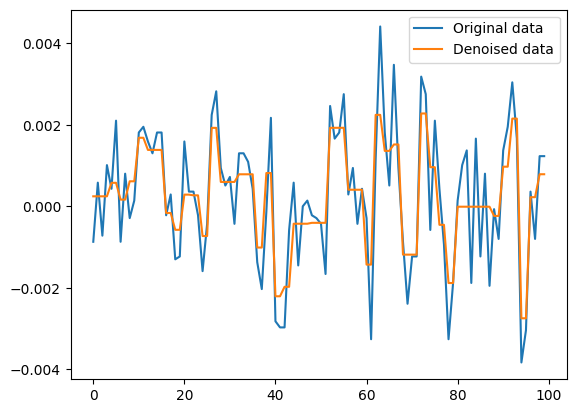

In [14]:
from skimage.restoration import denoise_wavelet

origin_Data = TRAIN_DF_RAW_01['C04'][:100]
TRAIN_DF_01_C01_DN = denoise_wavelet(origin_Data, method='BayesShrink')

plt.plot(origin_Data, label='Original data')
plt.plot(TRAIN_DF_01_C01_DN, label='Denoised data')
plt.legend()
plt.show()

#노이즈 제거(DWT)

In [77]:
from skimage.restoration import denoise_wavelet

def dataframe_DN(df):
  temp = pd.DataFrame(df)

  for colnam in VALID_COLUMNS_IN_TRAIN_DATASET[:3]:
    temp[colnam] = denoise_wavelet(df[colnam], method='BayesShrink',  sigma=0.1)
    #temp[colnam] = denoise_wavelet(df[colnam], method='VisuShrink', wavelet_levels=3, sigma=0.1)
  for colnam in VALID_COLUMNS_IN_TRAIN_DATASET[3:]:
    temp[colnam] = denoise_wavelet(df[colnam], method='BayesShrink',  sigma=0.4)
    #temp[colnam] = denoise_wavelet(df[colnam], method='VisuShrink', wavelet_levels=3, sigma=0.1) 
  return temp

In [78]:
TRAIN_DF_01 = dataframe_DN(TRAIN_DF_01)

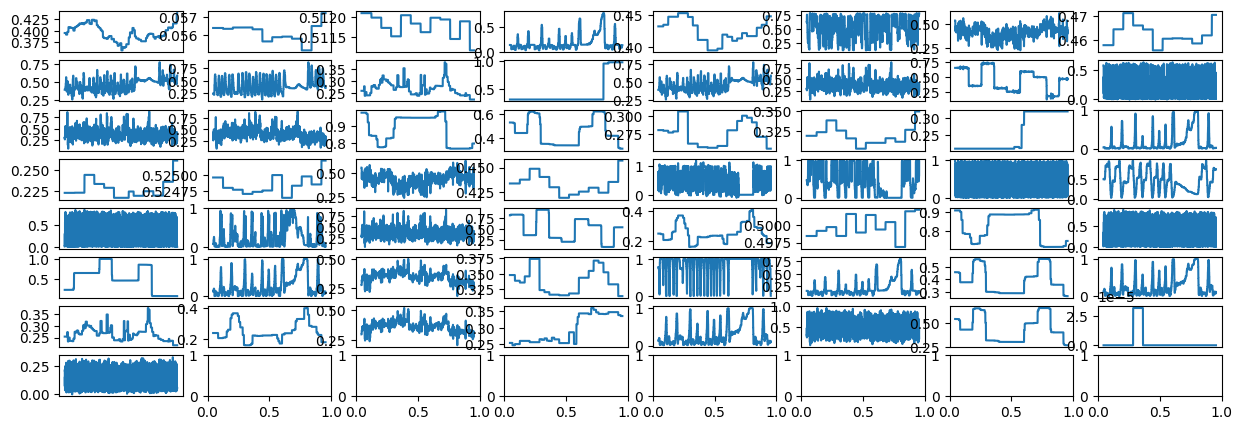

In [79]:
fig, axs = plt.subplots(nrows=8, ncols=8, figsize=(15, 5))

for i, c in enumerate(VALID_COLUMNS_IN_TRAIN_DATASET):
  k = i // 8
  j = i % 8
  #axs[k, j].plot(TRAIN_DF_RAW_01[c], label='Original data')
  axs[k, j].plot(TRAIN_DF_01[c], label='Denoised data')
  axs[k, j].xaxis.set_visible(False)

plt.show()

In [80]:
TRAIN_DF_02 = dataframe_DN(TRAIN_DF_02)
TRAIN_DF_03 = dataframe_DN(TRAIN_DF_03)
TRAIN_DF_04 = dataframe_DN(TRAIN_DF_04)
TRAIN_DF_05 = dataframe_DN(TRAIN_DF_05)
TRAIN_DF_06 = dataframe_DN(TRAIN_DF_06)

#노이즈 제거(지수평활법)

In [81]:
TRAIN_DF_01 = TRAIN_DF_01.ewm(alpha=0.9).mean()

In [82]:
TRAIN_DF_02 = TRAIN_DF_02.ewm(alpha=0.9).mean()
TRAIN_DF_03 = TRAIN_DF_03.ewm(alpha=0.9).mean()
TRAIN_DF_04 = TRAIN_DF_04.ewm(alpha=0.9).mean()
TRAIN_DF_05 = TRAIN_DF_05.ewm(alpha=0.9).mean()
TRAIN_DF_06 = TRAIN_DF_06.ewm(alpha=0.9).mean()

#모델 학습

In [83]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [84]:
window_size=12

windows_normal_01 = TRAIN_DF_01.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_01.shape[0]-window_size)[:, None]]

In [85]:
windows_normal_02 = TRAIN_DF_02.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_02.shape[0]-window_size)[:, None]]
windows_normal_03 = TRAIN_DF_03.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_03.shape[0]-window_size)[:, None]]
windows_normal_04 = TRAIN_DF_04.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_04.shape[0]-window_size)[:, None]]
windows_normal_05 = TRAIN_DF_05.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_05.shape[0]-window_size)[:, None]]
windows_normal_06 = TRAIN_DF_06.values[np.arange(window_size)[None, :] + np.arange(TRAIN_DF_06.shape[0]-window_size)[:, None]]

In [86]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal_01.shape[1]*windows_normal_01.shape[2]
z_size=windows_normal_01.shape[1]*hidden_size

In [87]:
train_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_01).float().view(([windows_normal_01.shape[0],w_size])))
train_loader_02 = data_utils.TensorDataset(torch.from_numpy(windows_normal_02).float().view(([windows_normal_02.shape[0],w_size])))
train_loader_03 = data_utils.TensorDataset(torch.from_numpy(windows_normal_03).float().view(([windows_normal_03.shape[0],w_size])))
train_loader_04 = data_utils.TensorDataset(torch.from_numpy(windows_normal_04).float().view(([windows_normal_04.shape[0],w_size])))
train_loader_05 = data_utils.TensorDataset(torch.from_numpy(windows_normal_05).float().view(([windows_normal_05.shape[0],w_size])))

val_loader_01 = data_utils.TensorDataset(torch.from_numpy(windows_normal_06).float().view(([windows_normal_06.shape[0],w_size])))

train_loader = torch.utils.data.DataLoader(data_utils.ConcatDataset(
    [train_loader_01,train_loader_02,train_loader_03, train_loader_04, train_loader_05]
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(val_loader_01, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [88]:
model = Autoencoder(w_size, z_size)
model = to_device(model,device)

In [89]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=684, out_features=342, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=342, out_features=171, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=171, out_features=1200, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1200, out_features=171, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=171, out_features=342, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=342, out_features=684, bias=True)
    (5): Sigmoid()
  )
)

In [90]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss: 0.0302
Epoch [1], val_loss: 0.0236
Epoch [2], val_loss: 0.0218
Epoch [3], val_loss: 0.0217
Epoch [4], val_loss: 0.0215
Epoch [5], val_loss: 0.0214
Epoch [6], val_loss: 0.0215
Epoch [7], val_loss: 0.0213
Epoch [8], val_loss: 0.0213
Epoch [9], val_loss: 0.0212
Epoch [10], val_loss: 0.0208
Epoch [11], val_loss: 0.0194
Epoch [12], val_loss: 0.0168
Epoch [13], val_loss: 0.0161
Epoch [14], val_loss: 0.0158
Epoch [15], val_loss: 0.0153
Epoch [16], val_loss: 0.0152
Epoch [17], val_loss: 0.0151
Epoch [18], val_loss: 0.0149
Epoch [19], val_loss: 0.0148
Epoch [20], val_loss: 0.0148
Epoch [21], val_loss: 0.0148
Epoch [22], val_loss: 0.0148
Epoch [23], val_loss: 0.0148
Epoch [24], val_loss: 0.0148
Epoch [25], val_loss: 0.0147
Epoch [26], val_loss: 0.0147
Epoch [27], val_loss: 0.0147
Epoch [28], val_loss: 0.0148
Epoch [29], val_loss: 0.0145
Epoch [30], val_loss: 0.0148
Epoch [31], val_loss: 0.0150
Epoch [32], val_loss: 0.0145
Epoch [33], val_loss: 0.0145
Epoch [34], val_loss: 0.

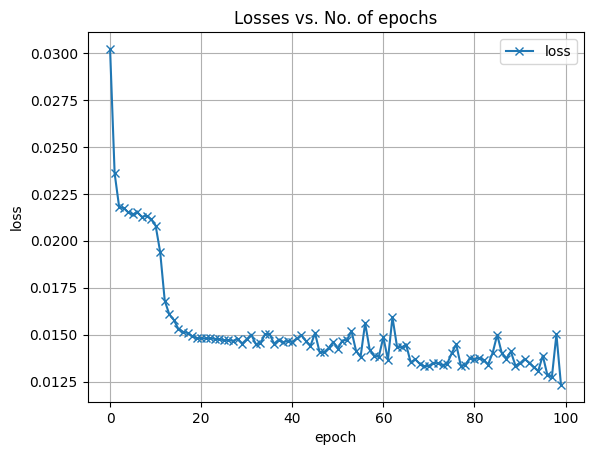

In [91]:
plot_history(history)

In [92]:
from os.path import join
from os import makedirs

%cd "{REPO_path}"
try:
  makedirs("models")
except:
  print("동일한 이름의 폴더가 이미 존재합니다.")

/content/drive/MyDrive/Colab Notebooks/HAI-Anomaly-Detection
동일한 이름의 폴더가 이미 존재합니다.


In [93]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder': model.decoder.state_dict()
            }, "./models/usad.pth")

In [94]:
checkpoint = torch.load("./models/usad.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder.load_state_dict(checkpoint['decoder'])

<All keys matched successfully>

#모델 평가를 위한 Val 데이터 준비

In [110]:
VALIDATION_DF_RAW = dataframe_from_csv(VALIDATION_DATASET[0])
VALIDATION_DF_RAW.reset_index(drop=True,inplace=True)

#Val 데이터 정규화

In [111]:
VALIDATION_DF_RAW_NM = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

#Val 데이터 노이즈 제거(지수평활법)

In [97]:
VALIDATION_DF = VALIDATION_DF_RAW_NM.ewm(alpha=0.9).mean()

#Val 데이터 노이즈 제거(DWT)

In [113]:
VALIDATION_DF = dataframe_DN(VALIDATION_DF_RAW_NM)

#Val 데이터를 활용한 모델 평가

다양한 모델을 사용하였습니다만, Train Set을 기준으로 Min-Max Normalize를 진행한 뒤, Validation Set과 Test Set에 대해 Train Dataset의 Min값 혹은 Max값을 넘어가는 값에 x2, x1.5를 해주었을 경우 성능이 소폭 향상되는 모습을 보여주었습니다.

Min-Max Normalization이 어느정도 Anomaly Detection에서 효과를 보여준다는 걸 보여주는 것으로도 볼 수 있고, 값이 튀는 장치들에 실제로도 보안위협이 들어왔다고 생각할 수도 있을 것 같습니다.

In [ ]:
for i in tqdm(range(VALIDATION_DF.shape[0])):
    for j in range(VALIDATION_DF.shape[1]):
        if VALIDATION_DF.iloc[i, j] < 0:
            VALIDATION_DF.iloc[i, j] = VALIDATION_DF.iloc[i, j] * 2
        elif VALIDATION_DF.iloc[i, j] > 1:
            VALIDATION_DF.iloc[i, j] = VALIDATION_DF.iloc[i, j] * 2

 30%|███       | 26309/86400 [00:56<02:08, 467.75it/s]

In [ ]:
val = VALIDATION_DF.values[np.arange(window_size)[None, :] + np.arange(VALIDATION_DF.shape[0]-window_size)[:, None]]

In [ ]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(val).float().view(([val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
results = testing(model,test_loader)

In [ ]:
labels = [int(label!= 0 ) for label in VALIDATION_DF_RAW["attack"].values]

In [ ]:
y_pred = np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = np.max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * np.array(peak) * np.array(0.3))
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [ ]:
THRESHOLD = 0.05
check_graph(y_pred, labels, piece=10, THRESHOLD=THRESHOLD)

In [ ]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [ ]:
LABELS = put_labels(y_pred, THRESHOLD)
LABELS, LABELS.shape

In [ ]:
a = np.zeros(window_size)
LABELS = np.append(a, LABELS, axis=0)

In [ ]:
TaPR = etapr.evaluate_haicon(anomalies=labels, predictions=LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

#후처리

In [ ]:
# 가중치를 조절한 Moving Average 사용

wMA10=[]
for idx in range(len(results)):
    if idx >= 10:
        wMA10.append((results[idx-10:idx].mean()*9+results[idx])/10)
    else:
        wMA10.append(results[idx])

wMA10=np.array(wMA10)
print(wMA10.shape)

In [ ]:
## 라벨 대상 / 빈 공간 0 채우기
# 날짜가 바뀌면서 시간이 연속되지 않는 구간은 부득이하게 정상으로 처리
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current >  ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [ ]:
LABELS_MA = put_labels(wMA10, THRESHOLD)
print(len(LABELS_MA), sum(LABELS_MA))

In [ ]:
ts = np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD])

In [ ]:
FINAL_LABELS_MA = fill_blank(ts, LABELS_MA, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
print(len(FINAL_LABELS_MA), sum(FINAL_LABELS_MA))

In [ ]:
# anomaly score가 미세한 차이로 threshold를 넘나드는 경우, 짧은 시간동안 오탐/미탐이 발생
# 탐지된 공격의 시간을 기준으로 정상과 anomaly를 판단하는 정책 적용

def Gray_Area(attacks):
    n_attacks = copy.deepcopy(attacks)
    for k in range(3):
        start = []   # start point
        finish = []  # finish point
        com = 0         # 처음에만 적용
        count = 0       # 연속된 수 카운트
        c = []          # 카운트 저장
        
        for i in range(1, len(n_attacks)):   # 라벨 파악
            if com == 0:                         # 처음에만 적용
                start.append(i)
                count = count + 1
                com = 1
            elif n_attacks[i - 1] != n_attacks[i]:  # 변화 발생
                finish.append(i - 1)
                c.append(count)
                count = 0
                start.append(i)
                count = count + 1
            else:                                # 카운트 (변화x)
                count = count + 1

        finish.append(len(n_attacks) - 1)
        c.append(finish[len(finish) - 1] - start[len(start) - 1] + 1)
        
        if k == 0:
            for i in range(0, len(start)):
                if c[i] < 100:
                    s = start[i]
                    f = finish[i] + 1

                    if n_attacks[start[i] - 1] == 1:
                        g1 = [1 for i in range(c[i])]
                        n_attacks[s:f] = g1
            
        elif k == 1:
            for i in range(0, len(start)):
                if c[i] < 10:
                    s = start[i]
                    f = finish[i] + 1

                    if n_attacks[start[i] - 1] == 0:
                        g0 = [0 for i in range(c[i])]
                        n_attacks[s:f] = g0
    
    return n_attacks

In [ ]:
# NewGray 적용

gray_LABELS=Gray_Area(FINAL_LABELS_MA)
print(gray_LABELS.shape, sum(gray_LABELS))

In [ ]:
pro_LABELS = list(gray_LABELS)

PRO_WINDOW_SIZE = 30

for i in range(PRO_WINDOW_SIZE, len(pro_LABELS)):
    if 1 <= sum(pro_LABELS[i-PRO_WINDOW_SIZE:i]):
        pro_LABELS[i-PRO_WINDOW_SIZE] = 1
    else:
        pro_LABELS[i-PRO_WINDOW_SIZE] = 0
        
print(sum(pro_LABELS))

In [ ]:
TaPR = etapr.evaluate_haicon(anomalies=labels, predictions=pro_LABELS)
print("Validation / THRESHOLD: " + str(THRESHOLD) + " / wMA10")
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")